In [281]:
import os
import shutil
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2
import glob
from sklearn.decomposition import PCA


if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))


# Limpieza

- Se borran las imágenes vacías (".png") y las eliminadas durante el procesado del "dataframe" de características (en el "notebook" llamado "images_data_processing"), y se actualiza paralelamente ese conjunto de datos quitándole las filas correspondientes a las imágenes "png" mencionadas

- El resultado es que en la carpeta de imágenes procesadas quedan tantos archivos ".jpg" como filas hay en el "dataframe" de características

In [269]:
df_images_data = pd.read_csv(r'data\processed\images_data_processed.csv', index_col='Id')
raw_images_path = r'data\raw\images'
processed_images_path = r'data\processed\images'


In [270]:
len(df_images_data)


5701

In [271]:
# Hay varias imágenes vacías. Todas están en formato "png". Hay que descartarlas antes que nada
no_delete_extension = '.jpg'
for (dirpath, dirnames, filenames) in os.walk(raw_images_path):
    for file in filenames:
        if no_delete_extension in file:
            if file != 'info_raw.txt':
                shutil.copyfile(raw_images_path + '\\' + file, processed_images_path + '\\' + file)


In [272]:
# Se han eliminado muchas filas del "dataframe", con lo que toca borrar las imágenes correspondientes
for (dirpath, dirnames, filenames) in os.walk(processed_images_path):
    for file in filenames:
        if file[:-4] not in df_images_data.index and file[:-4] != 'info_processed':
            os.remove(f'{dirpath}/{file}')


In [273]:
# Se crea una lista de las imágenes definitivas de la carpeta
filenames_list = []
for (dirpath, dirnames, filenames) in os.walk(processed_images_path):
    filenames_list += [file[:-4] for file in filenames if file != "info_processed.txt"]

len(filenames_list)


4519

In [274]:
# Asimismo, hay que borrar del "dataframe" los diamantes que se han sacado de la carpeta por no tener imagen
for index in df_images_data.index:
    if index not in filenames_list:
        df_images_data.drop(index, inplace=True)

len(df_images_data)


4519

In [275]:
# En el "dataframe" de características de las imágenes solo quedan los mismos diamantes que en la carpeta de imágenes "raw".
sorted(df_images_data.index) == sorted(filenames_list)


True

In [276]:
# Se renueva el "csv" con el "dataframe" de datos de las imágenes
df_images_data.to_csv(r'data\processed\images_data_processed.csv', index='Id')


# Reducción de componentes

- Se echa un vistazo a las características de una de las imágenes para tener una idea de como son

- Se elige específicamente un diamante que sea un tanto rojizo, para ver hasta qué punto es importante el color

- Todos los canales parecen ser importantes. Por tanto, habrá que elegir un modelo que trabaje con RGB y que acepte como mínimo 150 componentes

In [277]:
for image in glob.glob(processed_images_path+'/*.jpg'):
    if image.split('\\')[3] == '1507206.jpg':
        image_matrix = cv2.imread(image)

image_matrix


array([[[180, 182, 182],
        [180, 182, 182],
        [180, 182, 182],
        ...,
        [178, 180, 181],
        [178, 180, 181],
        [178, 180, 181]],

       [[180, 182, 182],
        [180, 182, 182],
        [180, 182, 182],
        ...,
        [178, 180, 181],
        [178, 180, 181],
        [178, 180, 181]],

       [[180, 182, 182],
        [180, 182, 182],
        [180, 182, 182],
        ...,
        [178, 180, 181],
        [178, 180, 181],
        [178, 180, 181]],

       ...,

       [[180, 182, 183],
        [179, 181, 182],
        [178, 180, 181],
        ...,
        [176, 178, 179],
        [176, 178, 179],
        [176, 178, 179]],

       [[180, 182, 183],
        [179, 181, 182],
        [179, 181, 182],
        ...,
        [176, 178, 179],
        [176, 178, 179],
        [176, 178, 179]],

       [[179, 181, 182],
        [179, 181, 182],
        [179, 181, 182],
        ...,
        [176, 178, 179],
        [176, 178, 179],
        [176, 178, 179]]

In [278]:
# Las imágenes están en RGB
image_matrix.shape


(300, 300, 3)

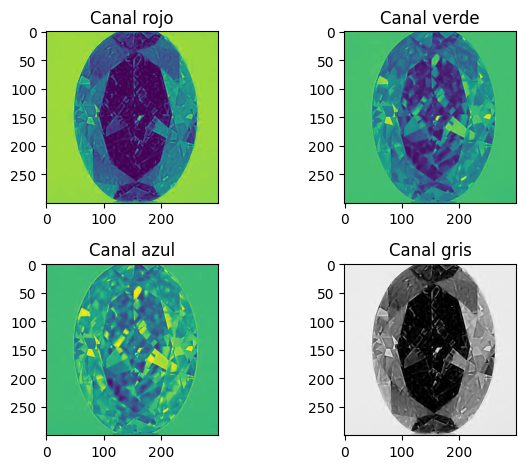

In [279]:
# Todos los canales parecen ser importantes
for number, channel in enumerate(['Canal rojo', 'Canal verde', 'Canal azul', 'Canal gris'], 1):
    plt.subplot(2, 2, number)
    plt.title(channel)
    if channel != 'Canal gris':
        plt.imshow(image_matrix[:, :, number-1])
    else:
        plt.imshow(image_matrix[:, :, 0], cmap=plt.cm.Greys_r)
plt.tight_layout()
plt.show()


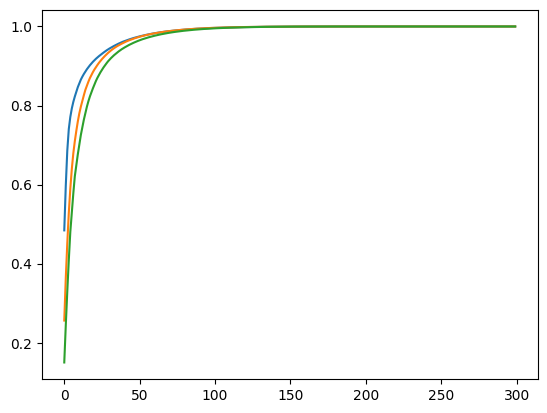

In [280]:
# Con 150 componentes ya se obtiene el máximo posible de información
for number in range(0, 3):
    pca=PCA()
    pca.fit(image_matrix[:, :, number])
    varianza = pca.explained_variance_ratio_
    varianza_acumualada = np.cumsum(varianza)
    plt.plot(range(len(varianza)),varianza_acumualada)  
plt.show()     
